# Libraries

In [1]:
import math
import pandas as pd
import numpy as np
import inflection 
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
from datetime import datetime
from datetime import timedelta

### Helper Functions

### Loading Data

Firstly, we are going to check all datasets out. We must verify what kind of fields there are in every dataset. 

In [2]:
data_raw_train = pd.read_csv("datasets/train.csv", low_memory=False)
data_raw_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
data_raw_test = pd.read_csv("datasets/test.csv", low_memory=False)
data_raw_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [4]:
data_raw_store = pd.read_csv("datasets/store.csv", low_memory=False)
data_raw_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
data_raw_sample = pd.read_csv("datasets/sample_submission.csv", low_memory=False)
data_raw_sample.head()

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


Based on the data above, we are going to merge the datasets "train" and "store". They are the ones with the relevant data we need to perform the forecast. 

In [6]:
data_raw = pd.merge(data_raw_train, data_raw_store, how="left", on="Store")
data_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1. Data Description

In [7]:
df1 = data_raw.copy()

#### Data fields meaning

**- Id:** an Id that represents a (Store, Date) duple within the test set.

**- Store:** a unique Id for each store.

**- Sales:** the turnover for any given day (this is what you are predicting).

**- Customers:** the number of customers on a given day.

**- Open:** an indicator for whether the store was open: 0 = closed, 1 = open.

**- StateHoliday:** indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None.

**- SchoolHoliday:** indicates if the (Store, Date) was affected by the closure of public schools.

**- StoreType:** differentiates between 4 different store models: a, b, c, d.

**- Assortment:** describes an assortment level: a = basic, b = extra, c = extended.

**- CompetitionDistance:** distance in meters to the nearest competitor store.

**- CompetitionOpenSince[Month/Year]:** gives the approximate year and month of the time the nearest competitor was opened.

**- Promo:** indicates whether a store is running a promo on that day.

**- Promo2:** Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating.

**- Promo2Since[Year/Week]:** describes the year and calendar week when the store started participating in Promo2.

**- PromoInterval:** describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.

## 1.1. Rename Columns

We are going to rename columns from camel case to snake case.

In [8]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case, cols_old))

#rename
df1.columns = cols_new

In [10]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [11]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3. Data Types

In [12]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [13]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
987126,22,7,2013-01-27,0,0,0,0,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


In [14]:
df1["state_holiday"].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [15]:
df1["date"] = pd.to_datetime( df1["date"] )

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA/Missing values

In [17]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [18]:
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA/Missing values

We have 03 different types of treating NA values:

**1.** Deleting all of them. It is easy and fast, but it results in a big loss. 

**2.** We may also use Machine Learning algorithms to fill them based on the column characteristics. e.g.: using median, mean or even clustering. 

**3.** We can fill them based on business decisions. That's the one we are going to use for now.   

#### competition_distance

This column means the "distance in meters to the nearest competitor store". We may assume that NA values are the ones greater than the maximum distance between the stores. 

In [19]:
df1["competition_distance"].max()

75860.0

As the maximum distance between competitors store is 75860.0 m, we may replace NA values with 200000.0. This replacement means, in other words, that the store has no competitor - based on the competition_distance field.  

In [20]:
df1["competition_distance"] = df1["competition_distance"].apply(lambda x: 200000.0 if math.isnan(x) else x)

#### competition_open_since_month

This field gives the approximate month of the time the nearest competitor was opened. We are going to use the month from the date field where there are NA values in the column competition_since_open_month. 

In [21]:
df1["competition_open_since_month"].min()

1.0

In [22]:
df1["competition_open_since_month"].unique()

array([ 9., 11., 12.,  4., 10.,  8., nan,  3.,  6.,  5.,  1.,  2.,  7.])

We are going to replace NA values with the month of the date of the row. 

In [23]:
df1["competition_open_since_month"] = df1.apply(lambda x: 
                                                x["date"].month if math.isnan(x["competition_open_since_month"]) 
                                                else x["competition_open_since_month"], axis=1)

#### competition_open_since_year

The procedure is very similar to the last treatment. However, we are going to use year instead of month. 

In [24]:
df1["competition_open_since_year"].unique()

array([2008., 2007., 2006., 2009., 2015., 2013., 2014., 2000., 2011.,
         nan, 2010., 2005., 1999., 2003., 2012., 2004., 2002., 1961.,
       1995., 2001., 1990., 1994., 1900., 1998.])

We are going to replace NA values with the month of the date of the row.

In [25]:
df1["competition_open_since_year"] = df1.apply(lambda x: 
                                                x["date"].year if math.isnan(x["competition_open_since_year"]) 
                                                else x["competition_open_since_year"], axis=1)

#### promo2_since_week

Promo2 is a continuing and consecutive promotion for some stores. promo2_since_week describes the week when the store started participating in Promo2. The treatment is similar to the last one above, yet using week as time period. 

In [26]:
df1["promo2_since_week"] = df1.apply(lambda x: 
                                    x["date"].week if math.isnan(x["promo2_since_week"]) 
                                    else x["promo2_since_week"], axis=1)

In [27]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week                    0
promo2_since_year               508031
promo_interval                  508031
dtype: int64

#### promo2_since_year

Similar to the treatment above. Yet, using year as time period. 

In [28]:
df1["promo2_since_year"] = df1.apply(lambda x: 
                                    x["date"].year if math.isnan(x["promo2_since_year"]) 
                                    else x["promo2_since_year"], axis=1)

In [29]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week                    0
promo2_since_year                    0
promo_interval                  508031
dtype: int64

#### promo_interval

This field describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.

For this treatment, we created a new column named "is_promo" where: 

1. 0 means there is no promo2 because promo_interval is 0 (previous NA).
2. 1 if the month from date field is in promo_interval field. 

In [30]:
month_map = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec", }

df1["promo_interval"].fillna(0, inplace=True)

df1["month_map"] = df1["date"].dt.month.map(month_map) 

df1["is_promo"] = df1[["promo_interval", "month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 
                                                              else 1 if x["month_map"] in x["promo_interval"].split(",") else 0, axis=1)

In [31]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
297320,207,1,2014-10-27,8416,1161,1,0,0,0,a,a,6870.0,10.0,2014.0,0,44.0,2014.0,0,Oct,0
318694,40,6,2014-10-04,6307,874,1,0,0,0,a,a,180.0,10.0,2014.0,1,45.0,2009.0,"Feb,May,Aug,Nov",Oct,0
495775,386,7,2014-04-13,0,0,0,0,0,0,d,c,1460.0,4.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",Apr,1
908712,773,1,2013-04-08,8384,1083,1,1,0,0,a,a,200.0,4.0,2013.0,0,15.0,2013.0,0,Apr,0
354316,156,3,2014-08-27,5682,670,1,0,0,1,a,a,2020.0,2.0,2011.0,1,14.0,2011.0,"Mar,Jun,Sept,Dec",Aug,0


In [32]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Data Types

Since we did many operations with the columns in the last section, it is quite important to check their types and change them if necessary. 

In [33]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [34]:
df1.sample(3)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
184911,937,1,2015-02-16,10848,775,1,1,0,0,d,a,2810.0,2.0,2015.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct",Feb,0
325486,339,6,2014-09-27,4004,587,1,0,0,0,a,c,2280.0,9.0,2014.0,1,10.0,2013.0,"Mar,Jun,Sept,Dec",Sep,0
372869,1089,5,2014-08-08,9688,1001,1,1,0,1,d,a,5220.0,5.0,2009.0,0,32.0,2014.0,0,Aug,0


In [35]:
df1["sales"] = df1["sales"].astype(float)
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)
df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)
df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)

In [36]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                  float64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [37]:
df1.sample(3)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
852707,518,2,2013-05-28,5565.0,445,1,1,0,1,d,c,3330.0,3,2015,1,13,2010,"Jan,Apr,Jul,Oct",May,0
912226,942,5,2013-04-05,5462.0,454,1,0,0,1,d,c,6860.0,4,2013,1,18,2011,"Jan,Apr,Jul,Oct",Apr,1
590891,727,6,2014-01-18,2654.0,299,1,0,0,0,a,a,2050.0,3,2007,0,3,2014,0,Jan,0


## 1.7 Descriptive Statistics

This section is necessary to know better our business and also to identify tendencies, problems or anomalies in our dataset. 

Firstly, let's separate the data into numerical and categorical attributes:

In [38]:
num_attributes = df1.select_dtypes(include=["int64", "float64"])
cat_attributes = df1.select_dtypes(exclude=["int64", "float64", "datetime64[ns]"])

In [39]:
num_attributes.columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'school_holiday', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo'],
      dtype='object')

In [40]:
cat_attributes.columns

Index(['state_holiday', 'store_type', 'assortment', 'promo_interval',
       'month_map'],
      dtype='object')

### 1.7.1. Numerical attributes

In this section, we are goint to work with two types of metrics:

1. Central tendency metrics: mean and median.
2. Dispersion metrics: standard deviation, minimum, maximum, range, skewness, and kurtosis. 

In [41]:
# Central tendency metrics
c1 = pd.DataFrame(num_attributes.apply( np.mean )).T
c2 = pd.DataFrame(num_attributes.apply( np.median )).T

# Dispersion metrics
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.min() )).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() )).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# Concatenate metric
m = pd.concat([d2, d3, d4, c1, c2, d1, d5, d6]).T.reset_index()
m.columns = ["attributes", "min", "max", "range", "mean", "median", "std", "skewness", "kurtosis"]

In [42]:
m

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


**Skewness:** how much a distribution of data deviates from a normal distribution.

1. Median greater than mean: right or negative skewness (mean minus median).
2. Median less than mean: left or positive skewness (mean minus median).
3. The median will always be in the direction of the highest concentration.
4. Median equals mean: normal distribution = no skewness.

ML algorithms need to train with unbiased data, that is, the distribution of the response variable (target) needs to be closer to a normal distribution.

Based on metrics above, we may see that mean is very close to the median. In some cases, they are so close to each other (according to the range) that two first rules does not match. However, it is good result because that means the distribution is very similar to a normal one and the Machine Learning model will not deal with a biased dataset.  

**Kurtosis:** data distribution around the mean and the existence of long tails. High kurtosis: concentration around the mean. A high kurtosis can bias the model.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

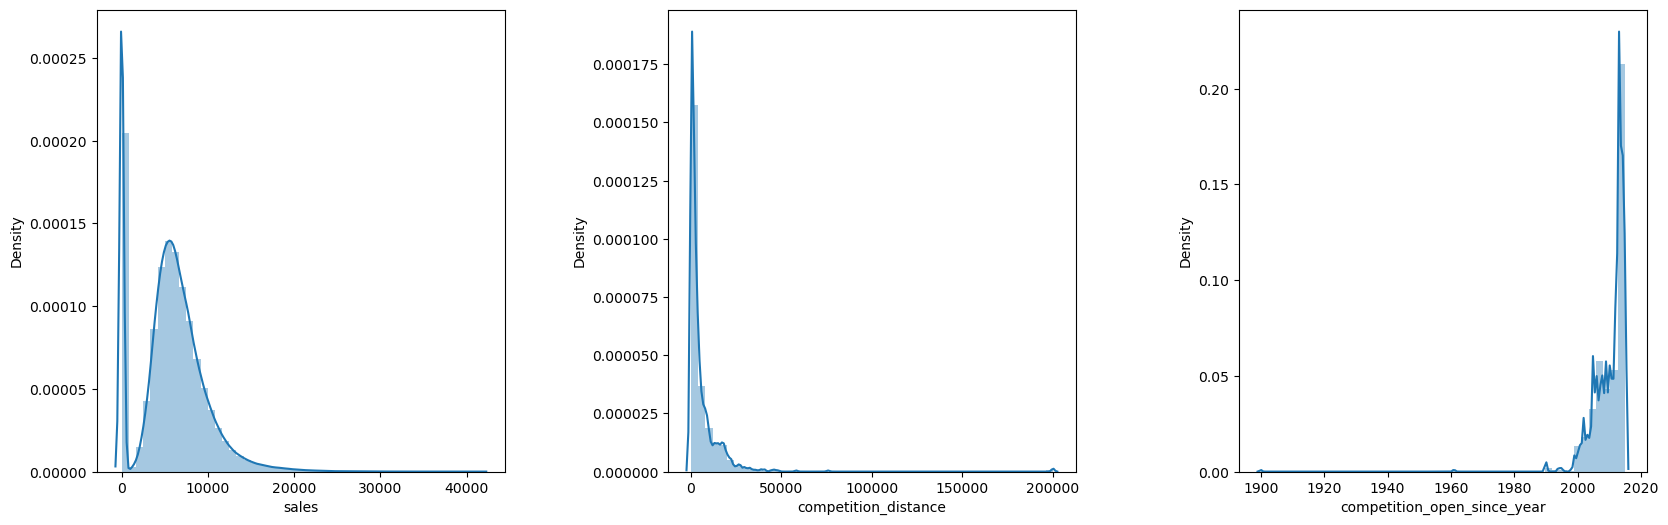

In [43]:
plt.figure(figsize = (20,6))

plt.subplot(131)
sns.distplot(df1["sales"])

plt.subplot(132)
sns.distplot(df1["competition_distance"])

plt.subplot(133)
sns.distplot(df1["competition_open_since_year"])

plt.subplots_adjust(wspace = 0.4)

1. For sales, which is our target, kurtosis is close to 1. This means the peak is not very high. Since median is less than mean, with sknewness around 0.64, we see a slightly left skewness. This value of skew is closer to a normal distribution. This considerations may be seen in the distribution chart for sales.

2. However, for competition distance, kurtosis is around 147. This represents a high peak and the existence of long tails. As the median is a way less than the mean, this results in skewness around 10. We may see a very proeminent skewness to the left in the distribution chart for competition distance.

3. A different behavior may be seen in the distribution chart for competition open since year. It has a -7 skewness, which represents a proeminent right skew. Since kurtosis is around 124, we see a high peak and a long tail in the distribution chart.

### 1.7.2. Categorical attributes

Let's begin with the unique value of each categorical attribute:

In [44]:
cat_attributes.apply(lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [45]:
cat_attributes.apply(lambda x: x.unique() )

state_holiday                                          [0, a, b, c]
store_type                                             [c, a, d, b]
assortment                                                [a, c, b]
promo_interval    [0, Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Mar,Jun,...
month_map         [Jul, Jun, May, Apr, Mar, Feb, Jan, Dec, Nov, ...
dtype: object

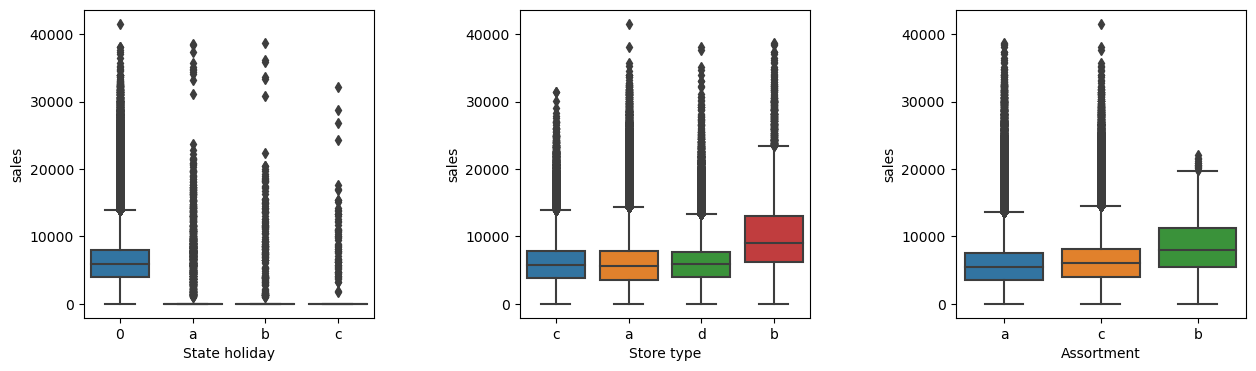

In [46]:
plt.figure(figsize = (15,4))

plt.subplot(131)
sns.boxplot(x="state_holiday" , y="sales", data=df1)
plt.xlabel("State holiday", fontsize=10)

plt.subplot(132)
sns.boxplot(x="store_type" , y="sales", data=df1)
plt.xlabel("Store type", fontsize=10)


plt.subplot(133)
sns.boxplot(x="assortment" , y="sales", data=df1)
plt.xlabel("Assortment", fontsize=10)

plt.subplots_adjust(wspace = 0.5)

For state holiday, we may perform a treatment. As we desire to see only the bevaior of holidays, we should ignore when this field is 0. Additionally, we must avoid when the sales are equal to 0. By doing this, we may see a better chart.

Text(0.5, 0, 'State holiday')

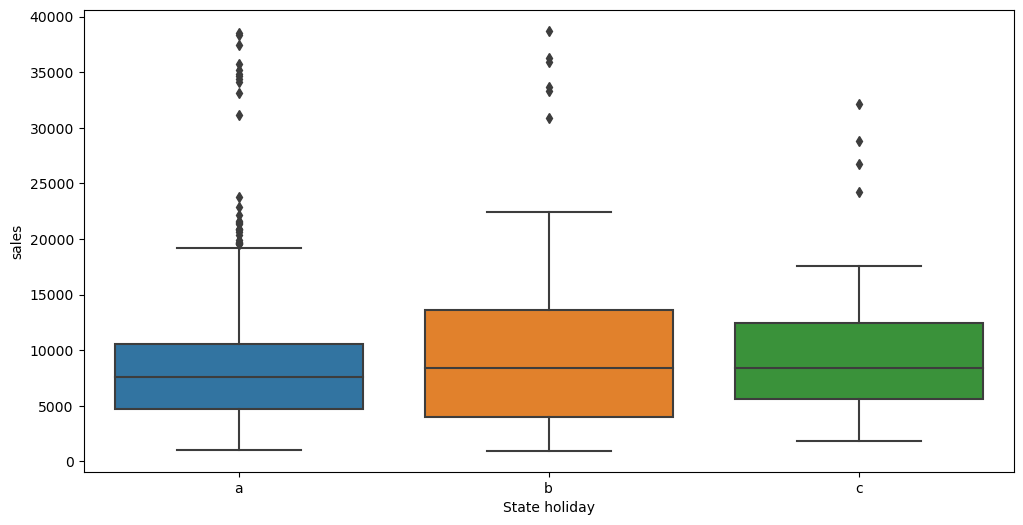

In [47]:
plt.figure(figsize = (12, 6))

aux1 = df1[(df1["state_holiday"] != "0") & (df1["sales"] > 0)]
sns.boxplot(x="state_holiday" , y="sales", data=aux1)
plt.xlabel("State holiday", fontsize=10)

1. We have higher sales for stete holidays of type b and c. Yet, b has a more homogeneous distribution around the median, that's it, for 25 and 75 quartiles.
2. Store type b has the highest sales values.
3. Assertment c presented the highest values for sales and also has much less outliers.

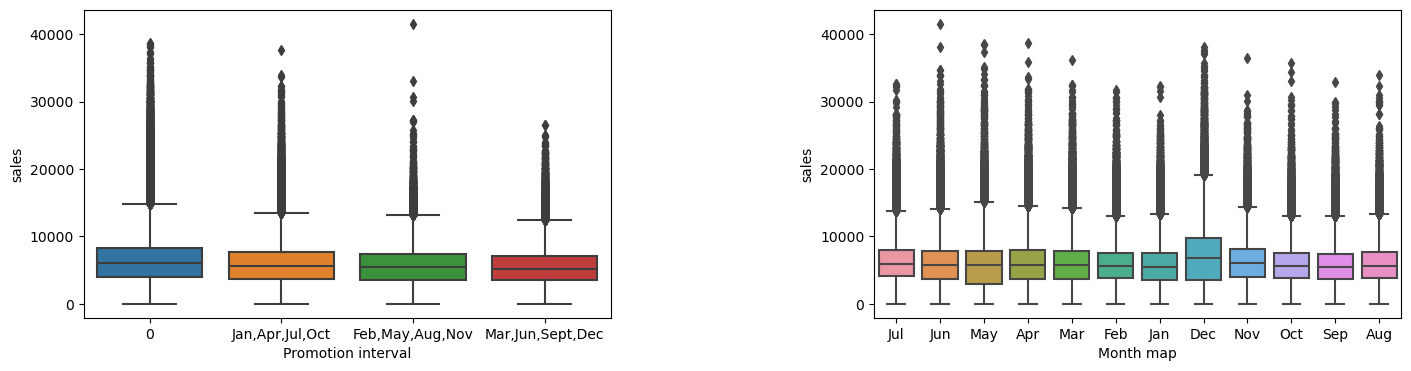

In [48]:
plt.figure(figsize = (17,4))

plt.subplot(121)
sns.boxplot(x="promo_interval" , y="sales", data=df1)
plt.xlabel("Promotion interval", fontsize=10)

plt.subplot(122)
sns.boxplot(x="month_map" , y="sales", data=df1)
plt.xlabel("Month map", fontsize=10)

plt.subplots_adjust(wspace = 0.5)

Text(0.5, 0, 'Promotion interval')

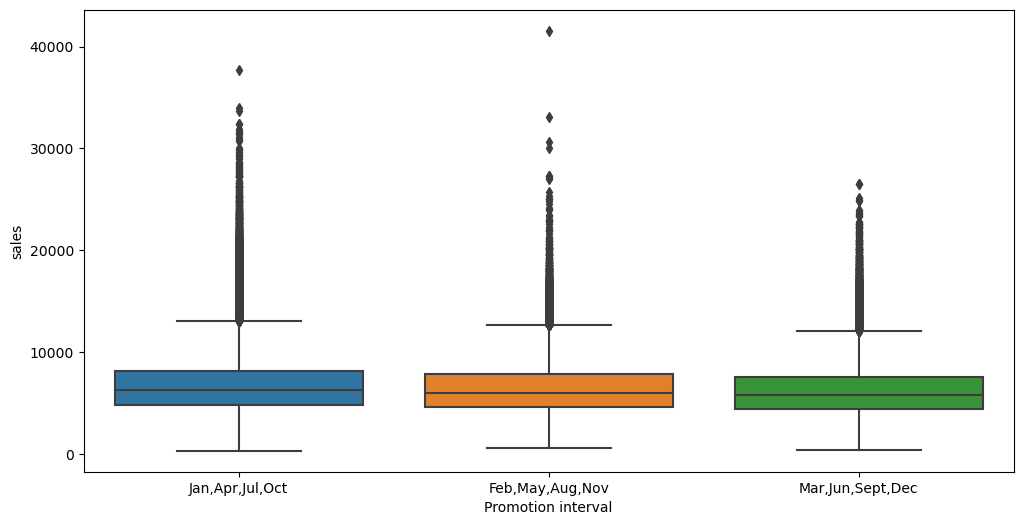

In [49]:
plt.figure(figsize = (12, 6))

aux2 = df1[(df1["promo_interval"] != 0) & (df1["sales"] > 0)]
sns.boxplot(x="promo_interval" , y="sales", data=aux2)
plt.xlabel("Promotion interval", fontsize=10)

1. Promotion interval equals to Jan, Apr, Jul, Oct presented a slightly higher sales. 
2. December is the month with the highest sales. 

# 2. Feature Engineering

This section is important to enhance the model performance. Furthermore, we must create new features before Exploratory Data Analysis section in order to evaluate them.  

In [50]:
df2 = df1.copy()

## 2.1. Hypotheses mind map

To generate some hypotheses, firstly we must make a mind map in order to identify the aspects of the business. For this project, we identified 5 reasons to enhance the daily store sales: location, customers, stores, seasonality, and products. The reasons and their criteria are down here.

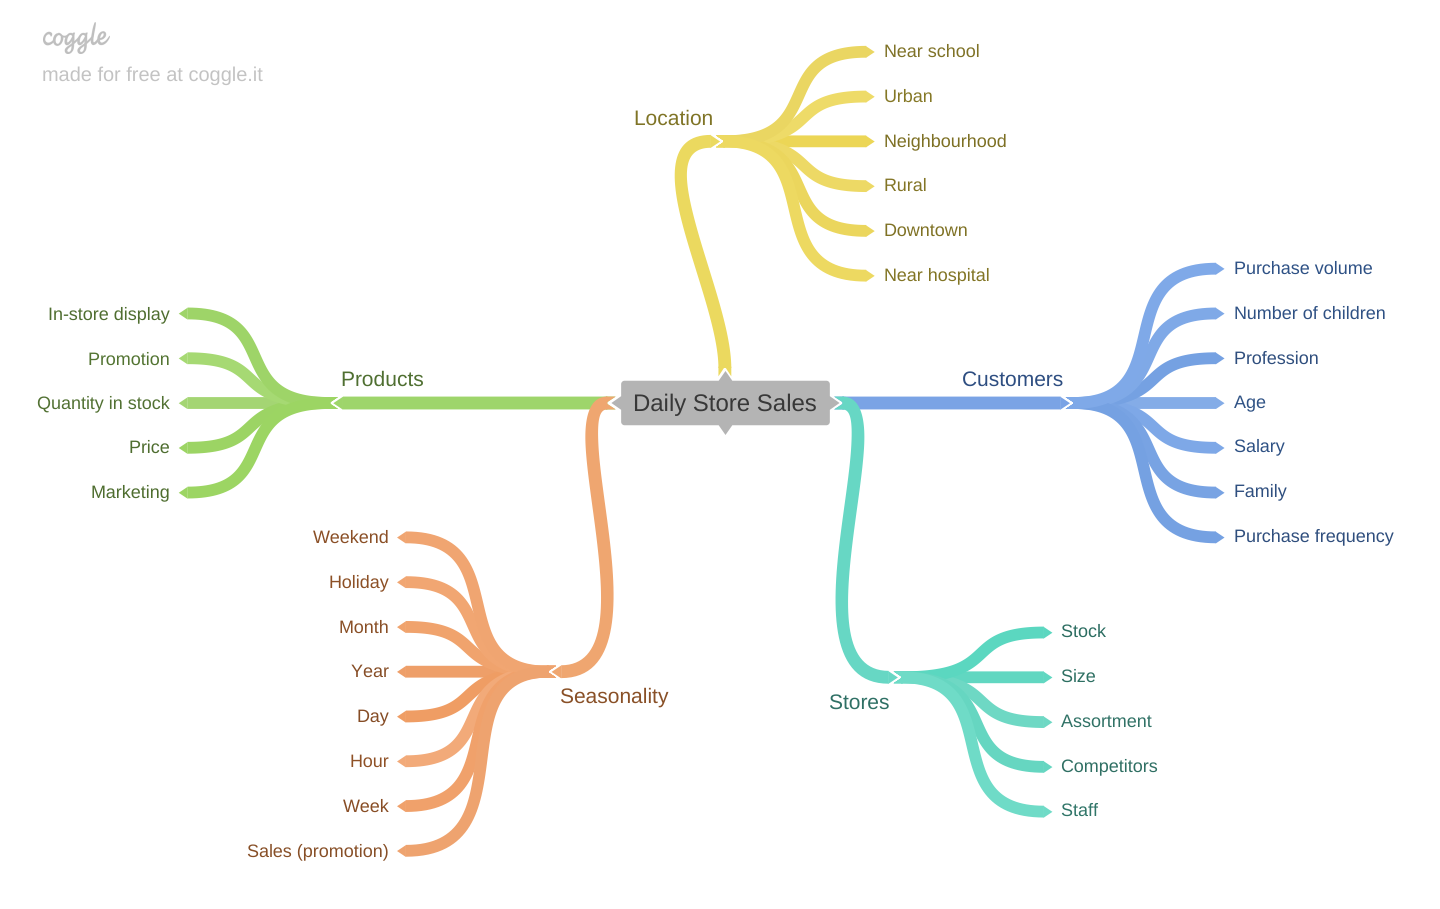

In [51]:
Image("images/HypothesesMindMap.png")

## 2.2. Hypotheses generation

Based on the mind map above, we created 3 hypotheses sections which may be seen below. 

### 2.1.1. Stores hypotheses

**1.** Stores with a higher number of staff should have higher sales.

**2.** Stores with larger stocks should have higher sales. 

**3.** Stores with larger sizes should have higher sales. 

**4.** Stores with bigger assortments should have higher sales.

**5.** Stores with closer competitors should have lower sales. 

**6.** Stores with long time competitors should have higher sales. 

### 2.1.2. Products hypotheses

**1.** Stores with higher investiments in marketing should have higher sales. 

**2.** Stores with higher in-store display should have higher sales.

**3.** Stores with lower product prices should have higher sales.

**4.** Stores with lower product prices for longer periods of time should have higher sales.

**5.** Stores with active promotions for longer periods should have higher sales.

**6.** Stores with more subsequent promotions should have higher sales. 

### 2.1.3. Seasonality hypotheses

**1.** Stores which join more holidays should have lower sales.

**2.** Stores which work in the second semester of the year should have higher sales.

**3.** Stores which work on weekends should have higher sales.

**4.** Stores which work on Christimas holiday should have higher sales.

**5.** Stores should have higher sales over year. 

**6.** Stores should have higher sales on day 10 for every month. 

**7.** Stores should have lower sales on school holidays. 

## 2.3. Hypotheses final list

To create the final list, we must think about the hypotheses which may be tested through available data. The mind map works as a brainstorming to help evaluate different scenarios. Yet, we do not have data for every hypothesis. Based on this criterion, we selected the final list down here. 

**1.** Stores with bigger assortments should have higher sales.

**2.** Stores with closer competitors should have lower sales.

**3.** Stores with long time competitors should have higher sales.

**4.** Stores with active promotions for longer periods should have higher sales.

**5.** Stores with more subsequent promotions should have higher sales.

**6.** Stores which work on Christimas holiday should have higher sales.

**7.** Stores should have higher sales over year.

**8.** Stores which work in the second semester of the year should have higher sales.

**9.** Stores should have higher sales on day 10 for every month.

**10.** Stores should have lowe sales on school holidays.

**11.** Stores which work on weekends should have higher sales.

## 2.4. Feature engineering

In [52]:
# year
df2["year"] = df2["date"].dt.year 

# month
df2["month"] = df2["date"].dt.month 

# day
df2["day"] = df2["date"].dt.day 

# week of year
df2["week_of_year"] = df2["date"].dt.weekofyear 

# year week
df2["year_week"] = df2["date"].dt.strftime("%Y-%W") 

# competition since
df2["competition_since"] = df2.apply(lambda x: datetime(year=x["competition_open_since_year"], month=x["competition_open_since_month"], day=1), axis=1)
df2["competition_time_month"] = ((df2["date"] - df2["competition_since"])/30).apply(lambda x: x.days).astype(int)


# promo since
df2["promo_since"] = df2["promo2_since_year"].astype(str) + "-" + df2["promo2_since_week"].astype(str)
df2["promo_since"] = df2["promo_since"].apply(lambda x: datetime.strptime(x + "-1", "%Y-%W-%w") - timedelta(days=7))
df2["promo_time_week"] = ((df2["date"] - df2["promo_since"])/30).apply(lambda x: x.days).astype(int)

# assortment
df2["assortment"] = df2["assortment"].apply(lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended")

# state holiday
df2["state_holiday"] = df2["state_holiday"].apply(lambda x: "public_holiday" if x == "a" else "easter_holiday" if x == "b" else "christmas" if x == "c" else "regular_day")

/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_10814/2736517694.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2["week_of_year"] = df2["date"].dt.weekofyear


In [53]:
df2.sample(5).T

,502141,910649,213355,242376,775845
store,62,480,391,460,591
day_of_week,1,6,3,4,1
date,2014-04-07 00:00:00,2013-04-06 00:00:00,2015-01-21 00:00:00,2014-12-25 00:00:00,2013-08-05 00:00:00
sales,7176.0,2322.0,4520.0,0.0,5195.0
customers,855,333,554,0,473
open,1,1,1,0,1
promo,0,0,0,0,0
state_holiday,regular_day,regular_day,regular_day,christmas,regular_day
school_holiday,0,0,0,1,1
store_type,a,a,a,a,a


# 3. Feature Filtering and Selection

The motivation of doing this section is business constraints. There are some fields that we will not use in this project due to lack of information (unavailable data) or predictability. For this project, this section is very easy to solve. However, in the real world this section demands so much more attention.

In [54]:
df3 = df2.copy()

## 3.1. Rows filtering

- We will not use open when is equal to zero. That's why open = 0 means the store was closed and then sales was also zero. It is easy to predict the value zero for sale, it happens when the store is close. Thus, we will not use this field when is 0. 
- Similarly, we want sales higher than zero. 

In [55]:
df3 = df3[(df3["open"] != 0) & (df3["sales"] > 0)]

## 3.2. Columns selection

- We may not predict the number of customers during the forecast. 
- Since we only have open = 1, this does not bring any variation. Thus, we do not need this column anymore. 
- We do not need column promo_interval, since we now have this information through column is_promo. 
- We either will not use column month_map because we now have the column month. 

In [56]:
cols_drop = ["customers", "open", "promo_interval", "month_map"]
df3 = df3.drop(cols_drop, axis=1)

# 4. Exploratory Data Analysis (EDA)

This section is important to understand the features and their impact. If we should list three objectives of this procedure, we would choose:

1. To gain business experience.
2. Validate business hypotheses. (insights)
3. Identify the most important features for the Machine Learning model. 

There are three types of analysis we are going to perform in this project: 

1. Univariate analysis: we must evaluate every feature separately. 
2. Bivariate analysis: here we evaluate how a feature impacts the target. 
3. Multivariate analysis: mainly we aim for the correlation of the features and their impact on the target.  

In [57]:
df4 = df3.copy()

## 4.1. Univariate Analysis 

### 4.1.1. Target feature

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


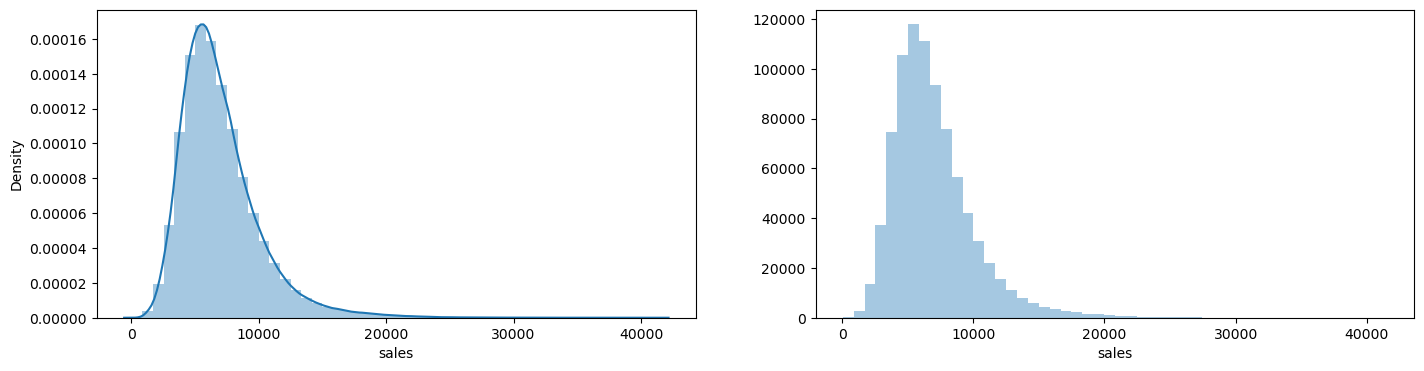

In [67]:
plt.figure(figsize = (17,4))

plt.subplot(1,2,1)
sns.distplot(df4["sales"])

plt.subplot(1,2,2)
sns.distplot(df4["sales"], kde=False)

plt.subplots_adjust(wspace = 0.2)

This distribution is close to a normal one. Yet, it has a kurtosis and also a skewness to the left (positive). Although ideally we want a distribution the closest to a normal as possible, this result is still enough to train the Machine Learning model.

In case we would rather modify the distribution in order to approximate it to a normal, we could apply the logarithm to the target feature, as follows:

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

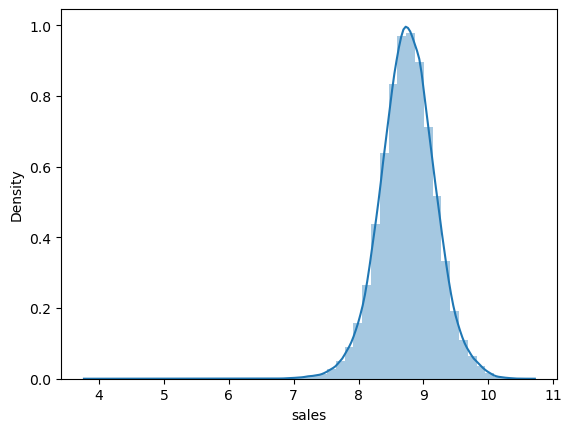

In [59]:
sns.distplot(np.log1p(df4["sales"]))

### 4.1.2. Numerical features

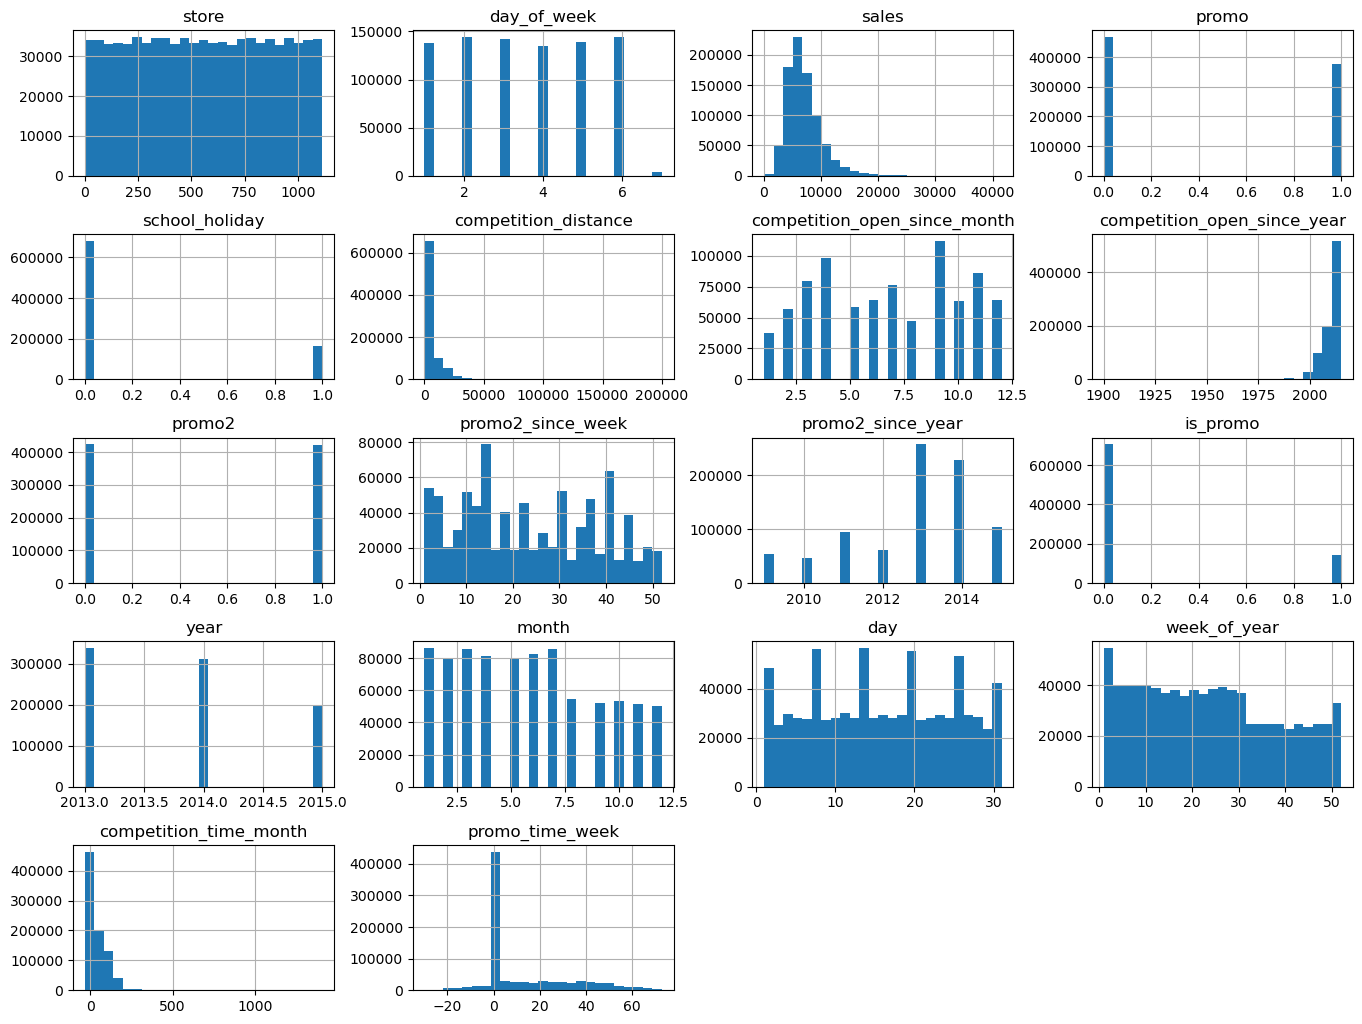

In [178]:
num_attributes = df4.select_dtypes(include=["int64", "float64"])

num_attributes.hist(bins=25);
plt.subplots_adjust(left=0.5, bottom=0.3, right=2.5, top=2.3, wspace=0.3, hspace=0.4)

**Store**, **day**, **promo2** and **day_of_week** almost do not offer relevant information to the model, since their values slightly vary from each other. The main insights from this analysis may be seen below:

- Sunday (7) is the least frequent day for purchases. (day_of_week)
- The majority of sales are around EUR 5000. (sales)
- The competitors distance are majority very near, close to zero meters. (competition_distance)
- The stores were open majority afer 2000's. (competition_open_since_year)
- Months between January and July are the most frequent for sales. (month)
- We have much more sales when there is no promotion. (is_promo)
- Although day (of the month) does not vary so much, there are some peaks we may explore. (day) 
- We have much more sales between 2013 and 2014 (promo2_since_year). Since we only have information after 2013 (year), we may suppose we have registered sales after this period. 

### 4.1.3. Categorical features

In [179]:
cat_attributes = df4.select_dtypes(exclude=["int64", "float64", "datetime64[ns]"])
cat_attributes.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


#### State holiday

In [181]:
df4["state_holiday"].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


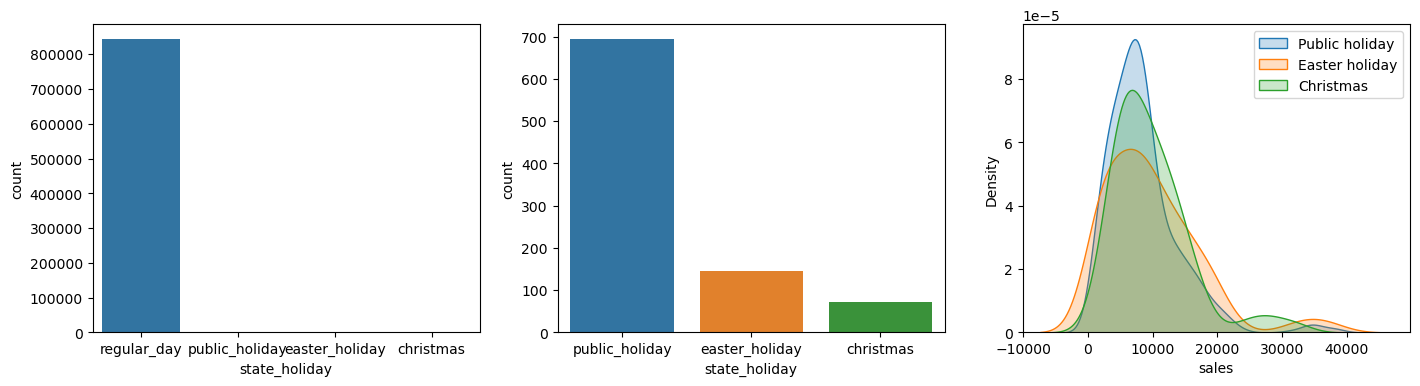

In [204]:
plt.figure(figsize = (17,4))

plt.subplot(1,3,1)
sns.countplot(df4["state_holiday"])

plt.subplot(1,3,2)
aux_sh = df4[df4["state_holiday"] != "regular_day"]
sns.countplot(aux_sh["state_holiday"])

plt.subplot(1,3,3)
sns.kdeplot(df4[df4["state_holiday"] == "public_holiday"]["sales"], label="Public holiday", shade=True)
sns.kdeplot(df4[df4["state_holiday"] == "easter_holiday"]["sales"], label="Easter holiday", shade=True)
sns.kdeplot(df4[df4["state_holiday"] == "christmas"]["sales"], label="Christmas", shade=True)
plt.legend()

In [186]:
df4["date"].max()

Timestamp('2015-07-31 00:00:00')

We should have the same count for Easter and for Christmas. However, it is not what we see in the second count plot. This may be explained by seen the max date. Since the max date is in July, we counted the sales in Easter for 2015, but did not for Christmas. 

While we have much more countability for Easter, compared to Christmas, this last one has more sales volume (third chart). 

#### Store type

In [206]:
df4["store_type"].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


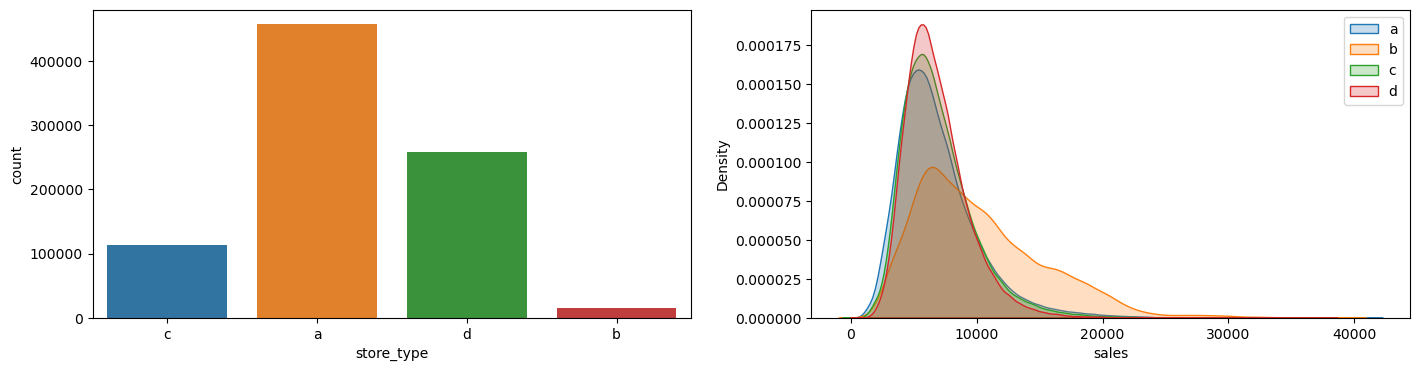

In [208]:
plt.figure(figsize = (17,4))

plt.subplot(1,2,1)
sns.countplot(df4["store_type"])

plt.subplot(1,2,2)
sns.kdeplot(df4[df4["store_type"] == "a"]["sales"], label="a", shade=True)
sns.kdeplot(df4[df4["store_type"] == "b"]["sales"], label="b", shade=True)
sns.kdeplot(df4[df4["store_type"] == "c"]["sales"], label="c", shade=True)
sns.kdeplot(df4[df4["store_type"] == "d"]["sales"], label="d", shade=True)
plt.legend()

- Store type a has a major count on our dataset. However, the sales volume is higher for store type d. 
- Store type b has the least count and also has the lowest sales volume. Yet, it has a broader range of sales. 

#### Assortment

In [209]:
df4["assortment"].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


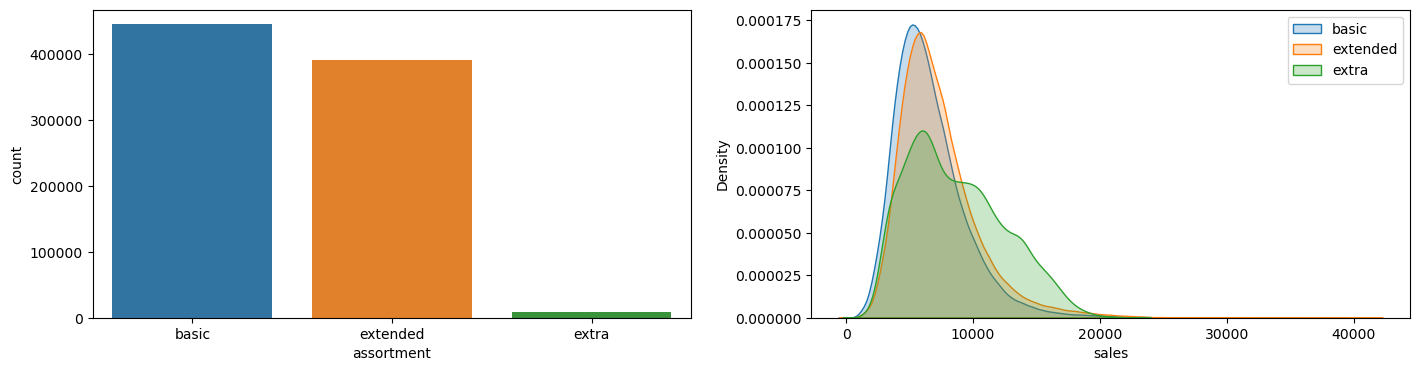

In [210]:
plt.figure(figsize = (17,4))

plt.subplot(1,2,1)
sns.countplot(df4["assortment"])

plt.subplot(1,2,2)
sns.kdeplot(df4[df4["assortment"] == "basic"]["sales"], label="basic", shade=True)
sns.kdeplot(df4[df4["assortment"] == "extended"]["sales"], label="extended", shade=True)
sns.kdeplot(df4[df4["assortment"] == "extra"]["sales"], label="extra", shade=True)
plt.legend()

- Basic, extended and extra has the same order for count and sales volume. As we expected, basic has the major count and sales volume.
- Extra has the sales volume more distributed. Assortments of type extra has a broader range of sales. 

## 4.2. Bivariate Analysis

As we have a bivariate analysis, we are going to test the hypotheses set in the section 2. In this section, we are going to evaluate the features related to the sales.

#### **H1.** Stores with bigger assortments should have higher sales.

In [216]:
aux1 = df4[["sales", "assortment"]].groupby("assortment").sum().reset_index()

aux2 = df4[["sales", "assortment", "year_week"]].groupby(["assortment", "year_week"]).sum().reset_index()
aux3 = aux2.pivot(index="year_week", columns="assortment", values="sales")
aux3.head()

assortment,basic,extended,extra
year_week,,,
2013-00,13434262.0,12425669.0,269404.0
2013-01,26007250.0,22917693.0,350279.0
2013-02,17970974.0,16029584.0,377207.0
2013-03,24392076.0,21243431.0,404662.0
2013-04,19972891.0,18130077.0,363061.0


In [233]:
aux4 = aux2[aux2["assortment"] == "extra"]
aux4 = aux4.pivot(index="year_week", columns="assortment", values="sales")
aux4.head()

assortment,extra
year_week,
2013-00,269404.0
2013-01,350279.0
2013-02,377207.0
2013-03,404662.0
2013-04,363061.0


<AxesSubplot:xlabel='year_week'>

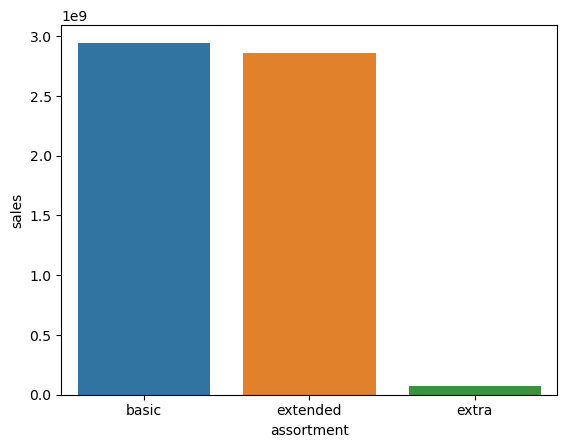

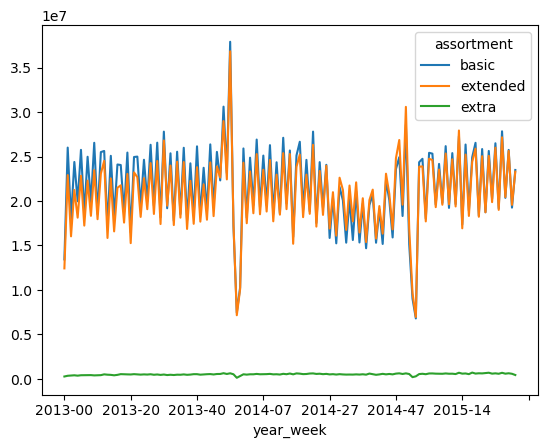

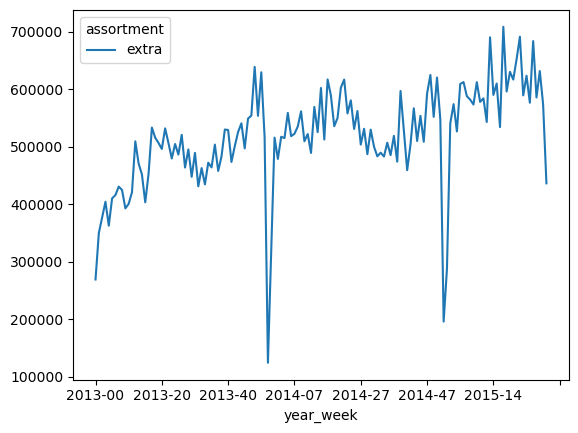

In [250]:
sns.barplot(x="assortment", y="sales", data=aux1)

aux3.plot()

aux4.plot()

- Assortments basic and extended have the highest sum of sales. Additionally, they have quite the same amount. What we must understand from this chart is that stores with bigger assortments (extra) have lower sales.
- As assortments of type extra presented the lowest sum of sales, we supposed that in some period the sales could have been higher. However, in the chart of sales per time for the three types of assortment, we do not see any moment that extra had higher sales.

#### **H2.** Stores with closer competitors should have lower sales.

#### **H3.** Stores with long time competitors should have higher sales.

## 4.3. Multivariate Analysis